In [1]:
# default_exp eda.overlap

# EDA Overlap

> API details.

In [1]:
# export
import gdown
import math

import numpy as np
import pandas as pd
import sentencepiece as spm

from joblib import Parallel, delayed
from pathlib import Path
from scipy.stats import pointbiserialr
from tqdm.auto import tqdm

In [2]:
#hide
from nbdev.showdoc import *

In [5]:
data_dir = Path("/home/jovyan/data")

In [4]:
# download using gdown T5 extension dataset
output_dir = data_dir / "t5-data.zip"
url = "https://drive.google.com/uc?id=1zKW5bOMjKHfX75d_uz8OF2teTb5Dse_M"
gdown.cached_download(url, str(output_dir), postprocess=gdown.extractall)

File exists: /home/jovyan/data/t5-data.zip


'/home/jovyan/data/t5-data.zip'

In [5]:
# download using gdown T5 extension test data with model performance
output_dir = data_dir / "t5-data-performance.zip"
url = "https://drive.google.com/uc?id=1EFPcdIpl-uez4e0918Yk4hQrLRyGczxf"
gdown.cached_download(url, str(output_dir), postprocess=gdown.extractall)

File exists: /home/jovyan/data/t5-data-performance.zip


'/home/jovyan/data/t5-data-performance.zip'

In [6]:
# download using gdown the sentencepiece model
output_path = data_dir / "dl4se_vocab.model"
url = "https://drive.google.com/uc?id=1KBVkhFZ80i1PW80aZexFGvJjyEClelX1"
gdown.cached_download(url, str(output_path))
s = spm.SentencePieceProcessor(model_file=str(output_path))

Cached Downloading: /home/jovyan/data/dl4se_vocab.model
Downloading...
From: https://drive.google.com/uc?id=1KBVkhFZ80i1PW80aZexFGvJjyEClelX1
To: /home/jovyan/.cache/gdown/tmpw49gs055/dl
100%|██████████| 795k/795k [00:00<00:00, 20.6MB/s]


In [7]:
# export
# This code was taken from https://gist.github.com/kylebgorman/1081951/bce3de986e4b05fc0b63d4d9e0cfa4bde6664365
def _dist(A, B, insertion, deletion, substitution):
    D = np.zeros((len(A) + 1, len(B) + 1))
    for i in range(len(A)):
        D[i + 1][0] = D[i][0] + deletion
    for j in range(len(B)):
        D[0][j + 1] = D[0][j] + insertion
    for i in range(len(A)): # fill out middle of matrix
        for j in range(len(B)):
            if A[i] == B[j]:
                D[i + 1][j + 1] = D[i][j] # aka, it's free.
            else:
                D[i + 1][j + 1] = min(D[i + 1][j] + insertion,
                                      D[i][j + 1] + deletion,
                                      D[i][j]     + substitution)
    return D

def levenshtein_distance(l1, l2, normalize=False):
    dist = _dist(l1, l2, 1, 1, 1)[-1][-1]
    if normalize:
        return 1. - dist / max(len(l1), len(l2))
    else:
        return dist

In [8]:
# export
# From: https://github.com/veekaybee/data/blob/master/samplesize.py
# SUPPORTED CONFIDENCE LEVELS: 50%, 68%, 90%, 95%, and 99%
confidence_level_constant = [50,.67], [68,.99], [90,1.64], [95,1.96], [99,2.57]
 
# CALCULATE THE SAMPLE SIZE
def sample_size(population_size, confidence_level, confidence_interval):
  Z = 0.0
  p = 0.5
  e = confidence_interval/100.0
  N = population_size
  n_0 = 0.0
  n = 0.0
 
  # LOOP THROUGH SUPPORTED CONFIDENCE LEVELS AND FIND THE NUM STD
  # DEVIATIONS FOR THAT CONFIDENCE LEVEL
  for i in confidence_level_constant:
    if i[0] == confidence_level:
      Z = i[1]
 
  if Z == 0.0:
    return -1
 
  # CALC SAMPLE SIZE
  n_0 = ((Z**2) * p * (1-p)) / (e**2)
 
  # ADJUST SAMPLE SIZE FOR FINITE POPULATION
  n = n_0 / (1 + ((n_0 - 1) / float(N)) )
 
  return int(math.ceil(n)) # THE SAMPLE SIZE

In [9]:
class Dataset:
    def __init__(self, trn_path, tst_path, tokenize=False) -> None:
        self.trn_path = trn_path
        self.tst_path = tst_path
        
        self.trn_df = pd.read_csv(self.trn_path, names=["input", "target"], sep="\t")
        self.tst_df = pd.read_csv(self.tst_path)

        if tokenize:
            self.trn_df["input"] = self.trn_df["input"].apply(lambda x: s.encode(x))
            self.trn_df["target"] = self.trn_df["target"].apply(lambda x: s.encode(x))
            self.tst_df["Groundtruth"] = self.tst_df["Groundtruth"].apply(lambda x: s.encode(x))
    
    def compute_overlap(self, parallelize=True, sample=True):
        if sample:
            size = sample_size(len(self.trn_df), confidence_level=95., confidence_interval=5.)
            print(f"Sample size: {size}")
            self.trn_df = self.trn_df.sample(size)

        if not parallelize:
            self.all_dists = []
            for tst_trgt in tqdm(self.tst_df.Groundtruth.values):
                dists = []
                for trn_trgt in self.trn_df.target.values:
                    dists.append(levenshtein_distance(tst_trgt, trn_trgt))
                self.all_dists.append(dists)
        else:
            self.all_dists = Parallel(n_jobs=96)(
                delayed(levenshtein_distance)(tst_trgt, trn_trgt)
                for tst_trgt in tqdm(self.tst_df.Groundtruth.values)
                for trn_trgt in self.trn_df.target.values
            )
            self.all_dists = np.array(self.all_dists)
            self.all_dists = self.all_dists.reshape((len(self.tst_df), len(self.trn_df)))

        self.min_dists = np.min(self.all_dists, axis=1)
        self.median_dists = np.median(self.all_dists, axis=1)
        self.max_dists = np.max(self.all_dists, axis=1)

        score_column = "BLEU" if "BLEU" in self.tst_df.columns else self.tst_df.columns[-1]
        df = pd.DataFrame({
            # "dists": self.all_dists,
            "min_dist": self.min_dists,
            "median_dist": self.median_dists,
            "max_dist": self.max_dists,
            "score": self.tst_df[score_column].values
        })
        return df

In [ ]:
finetune_ds_dir = data_dir / "datasets/tsv/fine-tuning"
performance_ds_dir = data_dir / "DataSnooping_Analysis_Data"

dfs = []
for dir in finetune_ds_dir.glob("*"):
    dataset_name = dir.name
    print(dataset_name)
    trn_path = finetune_ds_dir / f"{dataset_name}/training.tsv"
    if dataset_name == "MG":
        dataset_name = "Mutants"
    elif dataset_name == "CS":
        dataset_name = "CodeSummarization"
    tst_path = performance_ds_dir / f"{dataset_name}.csv"

    df = Dataset(trn_path, tst_path, tokenize=True).compute_overlap(parallelize=True, sample=True)
    df["dataset_name"] = dataset_name
    dfs.append(df)

df = pd.concat(dfs)
df.to_csv(data_dir / "t5-data-performance-overlap-tokenized.csv", index=False)

In [6]:
results_df = pd.read_csv(data_dir / "t5-data-performance-overlap-tokenized.csv")
results_df.describe()

,min_dist,median_dist,max_dist,score
count,149472.000000,149472.000000,149472.000000,149472.000000
mean,12.522579,20.043938,69.082470,0.352362
std,16.287783,23.332242,77.632789,0.376669
min,0.000000,7.000000,14.000000,0.000000
25%,5.000000,8.000000,16.000000,0.000000
50%,8.000000,11.000000,17.000000,0.191312
75%,11.000000,18.000000,100.000000,0.672196
max,356.000000,375.000000,379.000000,1.000000


<AxesSubplot:>

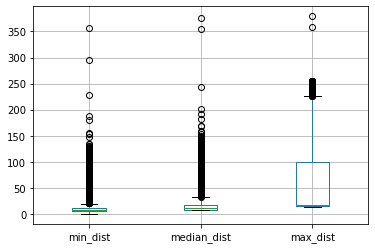

In [7]:
results_df.boxplot(column=["min_dist", "median_dist", "max_dist"])

<AxesSubplot:>

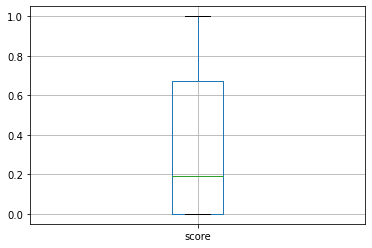

In [8]:
results_df.boxplot(column=["score"])

In [9]:
agraw_df = results_df[results_df.dataset_name == "AGraw"] # Binary score
agab_df = results_df[results_df.dataset_name == "AGabs"] # Binary score
bfsm_df = results_df[results_df.dataset_name == "BFsmall"] # Binary score
bfmd_df = results_df[results_df.dataset_name == "BFmedium"] # Binary score
mut_df = results_df[results_df.dataset_name == "Mutants"] # Continuous score
cs_df = results_df[results_df.dataset_name == "CodeSummarization"] # Continuous score

In [10]:
# From: https://towardsdatascience.com/point-biserial-correlation-with-python-f7cd591bd3b1
def point_biserial_correlation(df):
    corrs = []
    for col in df.columns:
        if col != "score" and col != "dataset_name":
            x = df["score"].values
            y = df[col].values
            pbc = pointbiserialr(x, y)
            corrs.append(pbc[0])
   
    return corrs

def pearson_correlation(df):
    return df["min_dist"].corr(df["score"]), df["median_dist"].corr(df["score"]), df["max_dist"].corr(df["score"])

min_agraw_corr, median_agraw_corr, max_agraw_corr = point_biserial_correlation(agraw_df)
min_agab_corr, median_agab_corr, max_agab_corr = point_biserial_correlation(agab_df)
min_bfsm_corr, median_bfsm_corr, max_bfsm_corr = point_biserial_correlation(bfsm_df)
min_bfmd_corr, median_bfmd_corr, max_bfmd_corr = point_biserial_correlation(bfmd_df)

min_mut_corr, median_mut_corr, max_mut_corr = pearson_correlation(mut_df)
min_cs_corr, median_cs_corr, max_cs_corr = pearson_correlation(cs_df)

In [11]:
min_agraw_corr, median_agraw_corr, max_agraw_corr

(-0.20674085888896696, -0.1427712449484566, 0.18968473382085918)

In [12]:
min_agab_corr, median_agab_corr, max_agab_corr

(-0.2107165676427643, -0.14033037696808537, 0.2898715146131562)

In [13]:
min_bfsm_corr, median_bfsm_corr, max_bfsm_corr

(-0.15341748700606433, -0.027188165617204586, 0.040650383273108916)

In [14]:
min_bfmd_corr, median_bfmd_corr, max_bfmd_corr

(-0.051578160652689185, -0.034035855192990155, 0.0077225817220179325)

In [15]:
min_mut_corr, median_mut_corr, max_mut_corr

(0.21472643961252413, 0.03262531616632887, -0.23030540151921175)

In [16]:
min_cs_corr, median_cs_corr, max_cs_corr

(-0.3796719614884238, -0.17354119554767558, -0.09338792745925713)

In [7]:
finetune_ds_dir = data_dir / "datasets/tsv/fine-tuning"
performance_ds_dir = data_dir / "DataSnooping_Analysis_Data"

dfs = []
for dir in finetune_ds_dir.glob("*"):
    dataset_name = dir.name
    print(dataset_name)
    trn_path = finetune_ds_dir / f"{dataset_name}/training.tsv"
    if dataset_name == "MG":
        dataset_name = "Mutants"
    elif dataset_name == "CS":
        dataset_name = "CodeSummarization"
    tst_path = performance_ds_dir / f"{dataset_name}.csv"

    df = Dataset(trn_path, tst_path).compute_overlap(parallelize=True, sample=True)
    df["dataset_name"] = dataset_name
    dfs.append(df)

df = pd.concat(dfs)
df.to_csv(data_dir / "t5-data-performance-overlap.csv", index=False)

AGraw
Sample size: 384


  0%|          | 0/18815 [00:00<?, ?it/s]

AGabs
Sample size: 383


  0%|          | 0/15810 [00:00<?, ?it/s]

BFsmall
Sample size: 382


  0%|          | 0/5835 [00:00<?, ?it/s]

MG
Sample size: 383


  0%|          | 0/11559 [00:00<?, ?it/s]

CS
Sample size: 385


  0%|          | 0/90908 [00:00<?, ?it/s]

BFmedium
Sample size: 382


  0%|          | 0/6545 [00:00<?, ?it/s]

In [10]:
results_df = pd.read_csv(data_dir / "t5-data-performance-overlap.csv")
results_df.head()

,min_dist,median_dist,max_dist,score,dataset_name
0,54.0,72.0,199.0,0.0,AGraw
1,5.0,25.0,209.0,1.0,AGraw
2,14.0,27.0,213.0,1.0,AGraw
3,26.0,41.0,197.0,0.0,AGraw
4,48.0,64.0,197.0,0.0,AGraw


In [11]:
results_df.describe()

,min_dist,median_dist,max_dist,score
count,149472.000000,149472.000000,149472.000000,149472.000000
mean,34.227126,54.851568,149.492467,0.429783
std,39.516985,46.584799,110.821879,0.372461
min,0.000000,21.000000,55.000000,0.000000
25%,14.000000,33.000000,66.000000,0.000001
50%,23.000000,37.000000,71.000000,0.363637
75%,37.000000,52.000000,234.000000,0.770260
max,1272.000000,1392.000000,1418.000000,1.000001


In [12]:
results_df.dataset_name.unique()

array(['AGraw', 'AGabs', 'BFsmall', 'Mutants', 'CodeSummarization',
       'BFmedium'], dtype=object)

<AxesSubplot:>

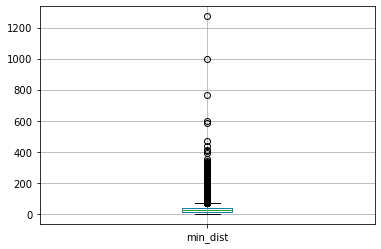

In [13]:
results_df.boxplot(column=["min_dist"])

<AxesSubplot:>

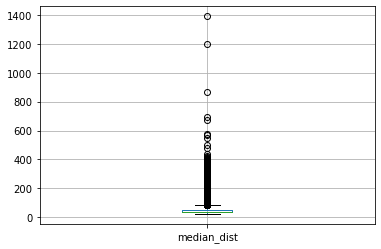

In [14]:
results_df.boxplot(column=["median_dist"])

<AxesSubplot:>

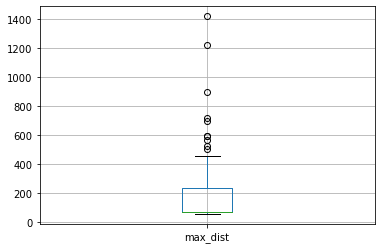

In [15]:
results_df.boxplot(column=["max_dist"])

<AxesSubplot:>

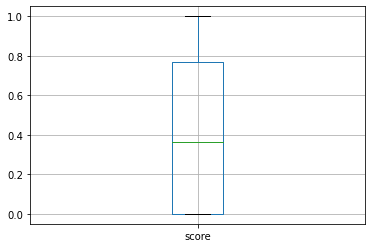

In [16]:
results_df.boxplot(column=["score"])

In [17]:
agraw_df = results_df[results_df.dataset_name == "AGraw"] # Binary score
agab_df = results_df[results_df.dataset_name == "AGabs"] # Binary score
bfsm_df = results_df[results_df.dataset_name == "BFsmall"] # Binary score
bfmd_df = results_df[results_df.dataset_name == "BFmedium"] # Binary score
mut_df = results_df[results_df.dataset_name == "Mutants"] # Continuous score
cs_df = results_df[results_df.dataset_name == "CodeSummarization"] # Continuous score

In [28]:
# From: https://towardsdatascience.com/point-biserial-correlation-with-python-f7cd591bd3b1
def point_biserial_correlation(df):
    corrs = []
    for col in df.columns:
        if col != "score" and col != "dataset_name":
            x = df["score"].values
            y = df[col].values
            pbc = pointbiserialr(x, y)
            corrs.append(pbc[0])
   
    return corrs

def pearson_correlation(df):
    return df["min_dist"].corr(df["score"]), df["median_dist"].corr(df["score"]), df["max_dist"].corr(df["score"])

min_agraw_corr, median_agraw_corr, max_agraw_corr = point_biserial_correlation(agraw_df)
min_agab_corr, median_agab_corr, max_agab_corr = point_biserial_correlation(agab_df)
min_bfsm_corr, median_bfsm_corr, max_bfsm_corr = point_biserial_correlation(bfsm_df)
min_bfmd_corr, median_bfmd_corr, max_bfmd_corr = point_biserial_correlation(bfmd_df)

min_mut_corr, median_mut_corr, max_mut_corr = pearson_correlation(mut_df)
min_cs_corr, median_cs_corr, max_cs_corr = pearson_correlation(cs_df)

In [29]:
min_agraw_corr, median_agraw_corr, max_agraw_corr

(-0.19544099112054408, -0.17372490477839275, 0.113084507247662)

In [30]:
min_agab_corr, median_agab_corr, max_agab_corr

(-0.21280413682842614, -0.1889615386352106, 0.233512645448679)

In [31]:
min_bfsm_corr, median_bfsm_corr, max_bfsm_corr

(-0.14966755220930258, -0.07999696402627492, 0.14870001813517694)

In [32]:
min_bfmd_corr, median_bfmd_corr, max_bfmd_corr

(-0.04661900781625006, -0.039005326418497674, 0.0143679508521035)

In [33]:
min_mut_corr, median_mut_corr, max_mut_corr

(0.1942475574771941, 0.122657677117703, -0.23029210921761165)

In [34]:
min_cs_corr, median_cs_corr, max_cs_corr

(-0.2903073756564675, -0.1347979073215824, -0.09331631074423853)

In [16]:
results_df["min_dist"].corr(results_df["score"]), results_df["median_dist"].corr(results_df["score"]), results_df["max_dist"].corr(results_df["score"])

(-0.22176577508958056, -0.18263469744583494, -0.10691389431476035)

In [24]:
cs_results_df = results_df[results_df.dataset_name == "CodeSummarization"]

In [25]:
cs_results_df["min_dist"].corr(cs_results_df["score"]), cs_results_df["median_dist"].corr(cs_results_df["score"]), cs_results_df["max_dist"].corr(cs_results_df["score"])

(-0.2903073756564675, -0.1347979073215824, -0.09331631074423853)

<AxesSubplot:xlabel='score', ylabel='median_dist'>

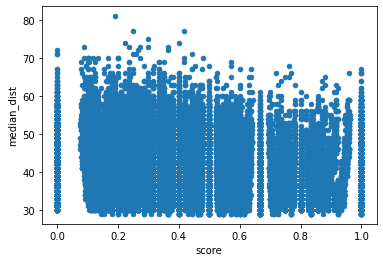

In [27]:
cs_results_df.plot(x="score", y="median_dist", kind="scatter")

In [28]:
mut_results_df = results_df[results_df.dataset_name == "Mutants"]

In [29]:
mut_results_df["min_dist"].corr(mut_results_df["score"]), mut_results_df["median_dist"].corr(mut_results_df["score"]), mut_results_df["max_dist"].corr(mut_results_df["score"])

(0.1942475574771941, 0.122657677117703, -0.23029210921761165)

<AxesSubplot:xlabel='score', ylabel='median_dist'>

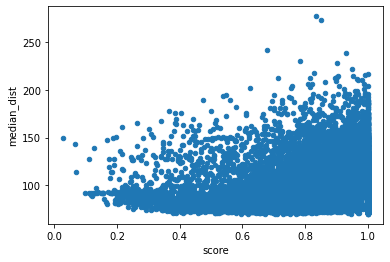

In [30]:
mut_results_df.plot(x="score", y="median_dist", kind="scatter")

<AxesSubplot:xlabel='score', ylabel='max_dist'>

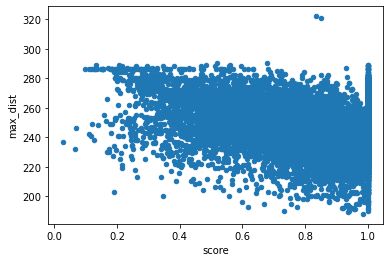

In [31]:
mut_results_df.plot(x="score", y="max_dist", kind="scatter")

In [ ]:
# From: https://towardsdatascience.com/point-biserial-correlation-with-python-f7cd591bd3b1
def point_biserial_correlation(x, y):
    # pbc of first question
    pbc = pointbiserialr(x, y)
    return pbc[0]

point_biserial_correlation(cs_results_df["score"], cs_results_df["min_dist"])

In [64]:
%%time
finetune_ds_dir = data_dir / "datasets/tsv/fine-tuning"
performance_ds_dir = data_dir / "DataSnooping_Analysis_Data"
sample_size=100

dfs = []
for dir in finetune_ds_dir.glob("*"):
    dataset_name = dir.name
    print(dataset_name)
    trn_path = finetune_ds_dir / f"{dataset_name}/training.tsv"
    if dataset_name == "MG":
        dataset_name = "Mutants"
    elif dataset_name == "CS":
        dataset_name = "CodeSummarization"
    tst_path = performance_ds_dir / f"{dataset_name}.csv"

    df = Dataset(trn_path, tst_path).compute_overlap(parallelize=True, sample_size=sample_size)
    df["dataset_name"] = dataset_name
    dfs.append(df)

df = pd.concat(dfs)

AGraw


  0%|          | 0/100 [00:00<?, ?it/s]

AGabs


  0%|          | 0/100 [00:00<?, ?it/s]

BFsmall


  0%|          | 0/100 [00:00<?, ?it/s]

MG


  0%|          | 0/100 [00:00<?, ?it/s]

CS


  0%|          | 0/100 [00:00<?, ?it/s]

BFmedium


  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 23.5 s, sys: 1.73 s, total: 25.2 s
Wall time: 14min 6s


In [65]:
%%time
finetune_ds_dir = data_dir / "datasets/tsv/fine-tuning"
performance_ds_dir = data_dir / "DataSnooping_Analysis_Data"
sample_size=100

dfs = []
for dir in finetune_ds_dir.glob("*"):
    dataset_name = dir.name
    print(dataset_name)
    trn_path = finetune_ds_dir / f"{dataset_name}/training.tsv"
    if dataset_name == "MG":
        dataset_name = "Mutants"
    elif dataset_name == "CS":
        dataset_name = "CodeSummarization"
    tst_path = performance_ds_dir / f"{dataset_name}.csv"

    df = Dataset(trn_path, tst_path).compute_overlap(parallelize=False, sample_size=sample_size)
    df["dataset_name"] = dataset_name
    dfs.append(df)

df = pd.concat(dfs)

AGraw


  0%|          | 0/100 [00:00<?, ?it/s]

AGabs


  0%|          | 0/100 [00:00<?, ?it/s]

BFsmall


  0%|          | 0/100 [00:00<?, ?it/s]

MG


  0%|          | 0/100 [00:00<?, ?it/s]

CS


  0%|          | 0/100 [00:00<?, ?it/s]

BFmedium


  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 55min 3s, sys: 1.2 s, total: 55min 4s
Wall time: 55min 4s


In [42]:
df[df["dataset_name"]=="Mutants"].head()

,min_dist,median_dist,max_dist,score,dataset_name
0,47.0,72.5,158.0,0.433893,Mutants
1,139.0,157.5,171.0,1.000000,Mutants
2,33.0,67.5,161.0,1.000000,Mutants
3,78.0,89.5,136.0,0.911597,Mutants
4,61.0,71.5,162.0,0.972414,Mutants


In [36]:
ds.compute_overlap(sample_size=10)

  0%|          | 0/10 [00:00<?, ?it/s]

,min_dist,median_dist,max_dist,score
0,10.0,23.0,79.0,False
1,8.0,23.5,80.0,True
2,9.0,27.5,92.0,True
3,10.0,28.5,92.0,True
4,25.0,32.0,74.0,False
5,27.0,32.0,83.0,True
6,19.0,24.5,79.0,False
7,13.0,26.5,87.0,True
8,26.0,50.5,75.0,False
9,9.0,27.5,92.0,False
